<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span><ul class="toc-item"><li><span><a href="#Создание-шифрующей-матрицы" data-toc-modified-id="Создание-шифрующей-матрицы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Создание шифрующей матрицы</a></span></li><li><span><a href="#Обучение-и-тестирование-модели-на-исходном-датасете" data-toc-modified-id="Обучение-и-тестирование-модели-на-исходном-датасете-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Обучение и тестирование модели на исходном датасете</a></span></li><li><span><a href="#Обучение-и-тестирование-модели-на-зашифрованном-датасете" data-toc-modified-id="Обучение-и-тестирование-модели-на-зашифрованном-датасете-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Обучение и тестирование модели на зашифрованном датасете</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

Импортируем нужные библиотеки, прочитаем файлы и посмотрим на их значения, размеры и типы данных.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


from IPython.display import display
pd.set_option('display.float_format', '{:.2f}'.format)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/insurance.csv')

In [3]:
df.info()
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.00,49600.00,1,0
1,0,46.00,38000.00,1,1
2,0,29.00,21000.00,0,0
3,0,21.00,41700.00,2,0
4,1,28.00,26100.00,0,0


Переведём возраст и зарплату в int.

In [4]:
df['Возраст'] = df['Возраст'].astype(int)
df['Зарплата'] = df['Зарплата'].astype(int)
display(df.head(5))

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41,49600,1,0
1,0,46,38000,1,1
2,0,29,21000,0,0
3,0,21,41700,2,0
4,1,28,26100,0,0


Посмотрим на распределение параметров:

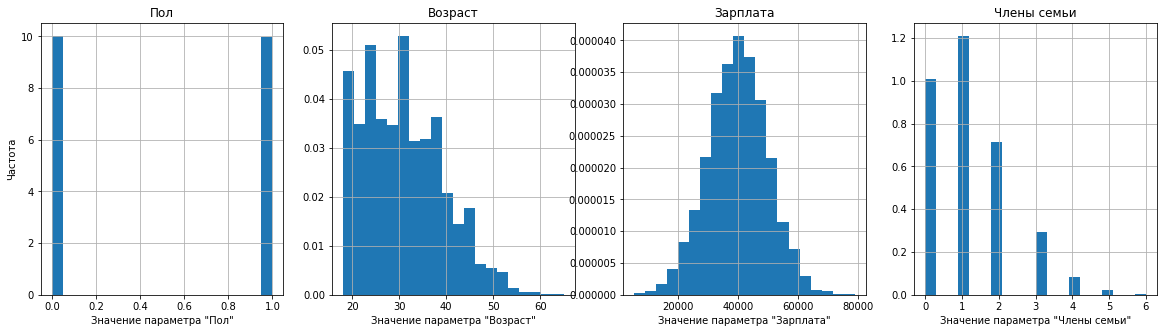

In [5]:
parameters = ['Пол', 'Возраст', 'Зарплата', 'Члены семьи']
fig, axes = plt.subplots(1, len(parameters), figsize=(20,5))
for i in range(len(parameters)):
    df[parameters[i]].hist(bins=20, density=True,figure=fig, ax=axes[i]).set_title(parameters[i])
    axes[i].set_xlabel('Значение параметра "' + parameters[i] + '"')
    axes[0].set_ylabel('Частота')

В данных нет перекоса в сторону одного из полов, гистораммы возраста и зарплаты выглядят хорошо. Возраст обрезан слева (нет левого "хвоста") - но это естественно. Количество детей также не вызывает подозрений: выбросы хоть и есть, но не "удивляющие". Не думаю, что стоит их удалять.

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:


\begin{equation}
a = Xw
\label{predictions} \tag{1}
\end{equation}


Задача обучения:

\begin{equation}
w = \arg\min_w MSE(Xw, y)
\label{learning_tast} \tag{2}
\end{equation}

Формула обучения:

\begin{equation}
w = (X^T X)^{-1} X^T y
\label{weights} \tag{3}
\end{equation}



**Вопрос:** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)

**Ответ:** Не изменится.

**Обоснование:** Пусть $Z=XA$, где $A -$ обратимая матрица. Тогда $X = ZA^{-1}$. Подставим в формулу предсказаний $\eqref{predictions}$ веса $\eqref{weights}$, выраженные через $Z$. Получим:

$a = X \left( X^T X \right)^{-1} X^T y = ZA^{-1} \left[ \left( Z A^{-1} \right)^T Z A^{-1} \right]^{-1} \left( Z A^{-1} \right) ^T y.$

Воспользуемся свойством $\left(AB\right)^T = B^TA^T$:

$a = ZA^{-1}\left[\left(A^{-1}\right)^TZ^TZA^{-1}\right]^{-1} \left(A^{-1}\right)^TZ^Ty.$

Так как $\left(A^{-1}\right)^T = \left(A^{T}\right)^{-1}$, $\left(AB\right)^{-1} = B^{-1}A^{-1}$ и $A -$ обратимая, получим:

$a = ZA^{-1}\left[\left(A^{-1}\right)^TZ^TZA^{-1}\right]^{-1} \left(A^{-1}\right)^TZ^Ty,$

$a = ZA^{-1}A\left(Z^TZ\right)^{-1}A^T\left(A^{-1}\right)^TZ^T$

$a = Z\left(Z^TZ\right)^{-1}Z^Ty = Zw_{new}.$

$w_{new} = \left(Z^TZ\right)^{-1}Z^Ty$


Модель, обученная на новых признаках $Z$, даёт те же самые предсказания $a$, что и модель, обученная на старых признаках. Новый вектор весов можно получить из старого, домножив в формуле $\eqref{weights}$ $X$ на матрицу $A^{-1}$

## Алгоритм преобразования

**Алгоритм**

1. Создать рандомную матрицу соответствующего принзакам размера (в данном случае $4\times4$).

2. Проверить её на обратимость.

3. Повторить предыдущие действия, пока проверка не даст положительный результат.

4. Домножить признаки на полученную матрицу.

**Обоснование**

Обоснование показано в "Умножении матриц". Модель, обученная методом линейной регрессии на новых признаках $Z$, даёт те же самые предсказания $a$, что и модель, обученная на старых признаках, при условии, что новые признаки получены домножением старых на обратимую матрицу. При этом достигнется шифровка признаков.

## Проверка алгоритма

Разделим датасет на целевой признак и фичи.

In [6]:
target = df['Страховые выплаты']
features = df.drop('Страховые выплаты', axis=1)

### Создание шифрующей матрицы

Создать рандомную обратимую матрицу соответствующего принзакам размера (в данном случае $4\times4$).

In [7]:
determinant_crypto_matrix = 0

while determinant_crypto_matrix == 0:
    crypto_matrix = np.random.sample((features.shape[1], features.shape[1]))
    determinant_crypto_matrix = np.linalg.det(crypto_matrix)

In [8]:
print('Проверка шифрующей матрицы на обратимость')
print()
print(crypto_matrix @ np.linalg.inv(crypto_matrix))

Проверка шифрующей матрицы на обратимость

[[ 1.00000000e+00 -3.07310007e-16 -9.24907721e-17 -5.68669477e-17]
 [-3.45295192e-16  1.00000000e+00  1.56622463e-16 -1.56574017e-16]
 [-1.26246982e-16 -6.93984357e-17  1.00000000e+00 -5.93453788e-17]
 [ 1.16653014e-16 -4.68111970e-17 -1.22498510e-16  1.00000000e+00]]


С точностью до 16го знака после запятой при умножении шифрующей матрицы на обратную ей получили единичную матрицу. Считаем, что шифрующая матрица - обратима.

### Обучение и тестирование модели на исходном датасете

Разобьем выборку на обучающую и тестовую.

In [9]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=123)
print('Размер обучающих фич:', features_train.shape)
print('Размер тестовых фич:', features_test.shape)

Размер обучающих фич: (4000, 4)
Размер тестовых фич: (1000, 4)


Масштабируем признаки.

In [10]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

display(features_train)

array([[-0.99700449,  1.78769966, -0.10038057, -0.18493026],
       [ 1.00300451,  2.02443796, -2.62745281,  0.72493571],
       [ 1.00300451,  0.60400817, -0.63398546, -0.18493026],
       ...,
       [-0.99700449, -0.57968331, -0.45276116, -0.18493026],
       [-0.99700449, -0.10620672, -1.51997095, -0.18493026],
       [ 1.00300451,  0.13053158, -1.20786243, -0.18493026]])

Построим модель.

In [11]:
def train_model_get_predictions(features_train, features_test, target_train, target_test):
    """
    Строит модель, выводит R2-метрику
    """
    model = LinearRegression()
    model.fit(features_train, target_train) 
    predictions_test = model.predict(features_test)
    r2 = r2_score(target_test, predictions_test)
    print("R2 модели на тестовой выборке:", r2)
    return r2

In [12]:
r2_before_transform = train_model_get_predictions(features_train, features_test, target_train, target_test)

R2 модели на тестовой выборке: 0.4326945642340617


### Обучение и тестирование модели на зашифрованном датасете

Трансформируем матрицу признаков и посмотрим, насколько понятны данные после трансформации.

In [13]:
features_transformed = features @ crypto_matrix
display(features_transformed.head())

,0,1,2,3
0,30780.75,23064.49,4750.39,17594.15
1,23595.21,17675.16,3645.53,13482.30
2,13042.59,9769.02,2015.70,7451.06
3,25865.12,19385.53,3989.02,14790.04
4,16203.44,12139.39,2502.00,9259.10


Отлично. Непонятны. Разобьём выборку на обучающую и тестовую, масштабируем признаки, обучим модель и посчитаем R2-метрику.

In [14]:
features_train, features_test, target_train, target_test = train_test_split(
    features_transformed, target, test_size=0.2, random_state=123)

scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

r2_after_transform = train_model_get_predictions(features_train, features_test, target_train, target_test)

R2 модели на тестовой выборке: 0.4326945642340537


In [15]:
print('Разница метрик:', np.abs(r2_after_transform - r2_before_transform))

Разница метрик: 7.993605777301127e-15


После шифрования метрика изменилась в 15 знаке после запятой. Считаем это пренебрежимо малым значением.

## Вывод

Нужно было защитить данные клиентов. Для этого был разработан такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. 

В работе представлено математическое обоснование, что модель, обученная на преобразованных признаках, даёт те же самые предсказания, что и модель, обученная на исходных признаках.

Проверено, что метод не изменяет качество работы модели линейной регрессии, а данные при этом становятся не такими очевидными - по крайней мере, для глаз.